In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import requests
import matplotlib as plt

In [2]:
url = "https://files.consumerfinance.gov/ccdb/complaints.csv.zip"
response = requests.get(url)
data = pd.read_csv(response.url)

<ipython-input-2-5fce62c78fd5>:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(response.url)


In [3]:
print(data.head())

  Date received                                            Product  \
0    2023-07-22  Credit reporting, credit repair services, or o...   
1    2023-08-25  Credit reporting or other personal consumer re...   
2    2023-08-24  Credit reporting, credit repair services, or o...   
3    2023-08-25  Credit reporting or other personal consumer re...   
4    2023-08-23  Credit reporting, credit repair services, or o...   

                      Sub-product  \
0                Credit reporting   
1                Credit reporting   
2                Credit reporting   
3                Credit reporting   
4  Other personal consumer report   

                                               Issue  \
0               Incorrect information on your report   
1               Incorrect information on your report   
2  Problem with a credit reporting company's inve...   
3                        Improper use of your report   
4               Incorrect information on your report   

                   

In [4]:
print("Dataset Information:")
print(data.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4101381 entries, 0 to 4101380
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(1

In [5]:
print("\nSummary Statistics:")
print(data.describe())


Summary Statistics:
       Complaint ID
count  4.101381e+06
mean   4.350486e+06
std    2.040780e+06
min    1.000000e+00
25%    2.883892e+06
50%    4.294108e+06
75%    6.186028e+06
max    7.593229e+06


In [6]:
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Date received                         0
Product                               0
Sub-product                      235291
Issue                                 0
Sub-issue                        716954
Consumer complaint narrative    2615783
Company public response         2200311
Company                               0
State                             43240
ZIP code                          30213
Tags                            3673906
Consumer consent provided?       903652
Submitted via                         0
Date sent to company                  0
Company response to consumer          5
Timely response?                      0
Consumer disputed?              3333023
Complaint ID                          0
dtype: int64


In [7]:
data["Date received"] = pd.to_datetime(data["Date received"])
data["Date sent to company"] = pd.to_datetime(data["Date sent to company"])

In [8]:
data["Year received"] = data["Date received"].dt.year
data["Month received"] = data["Date received"].dt.month
data["Day received"] = data["Date received"].dt.day

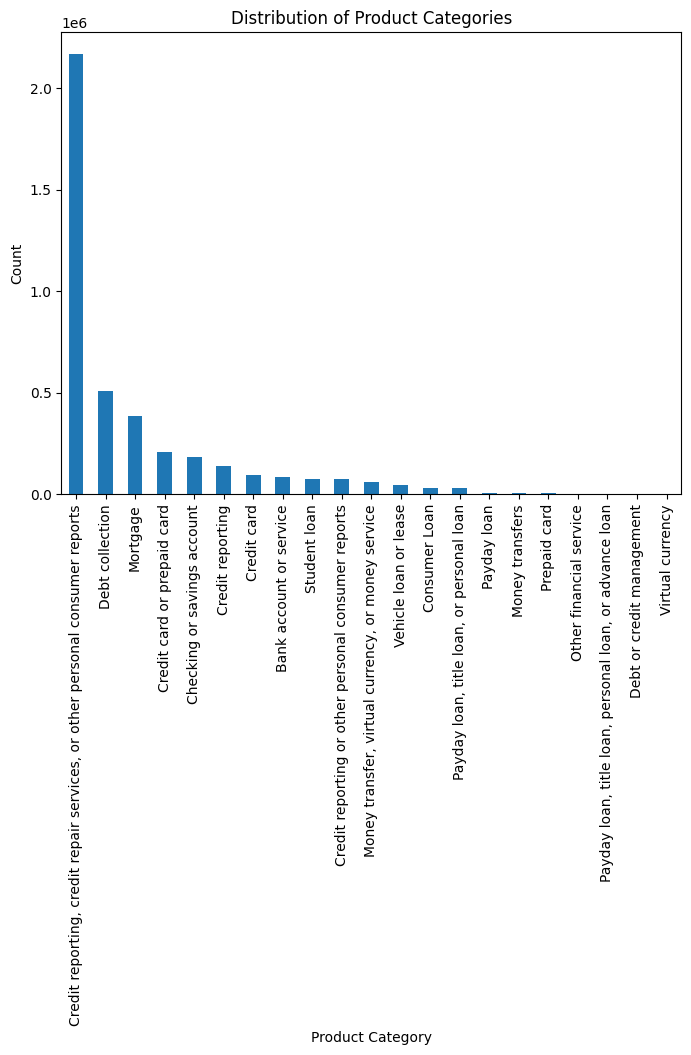

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
data["Product"].value_counts().plot(kind="bar")
plt.title("Distribution of Product Categories")
plt.xlabel("Product Category")
plt.ylabel("Count")
plt.show()

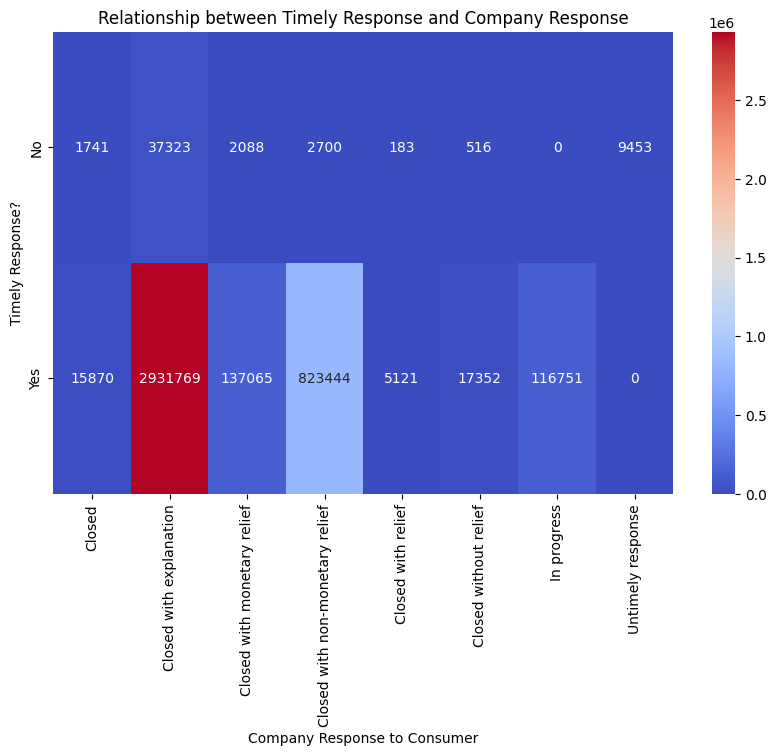

In [10]:
import seaborn as sns
cross_tab = pd.crosstab(data["Timely response?"], data["Company response to consumer"])
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap="coolwarm", fmt="d", cbar=True)
plt.title("Relationship between Timely Response and Company Response")
plt.xlabel("Company Response to Consumer")
plt.ylabel("Timely Response?")
plt.show()

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
data = data[['Product', 'Consumer complaint narrative']]

In [13]:
data = data.dropna()

In [14]:
categories = ['Credit reporting, repair, or other', 'Debt collection', 'Consumer Loan', 'Mortgage']
data = data[data['Product'].isin(categories)]

In [15]:
data.reset_index(drop=True, inplace=True)

In [16]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    return text

In [18]:
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(preprocess_text)

In [19]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(data['Consumer complaint narrative'])
y = data['Product']

In [20]:
sampled_data = data.sample(n=500, random_state=42)

In [21]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(sampled_data['Consumer complaint narrative'])
y = sampled_data['Product']

In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [23]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(sampled_data['Consumer complaint narrative'])
y = sampled_data['Product']

In [26]:
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', C=1.0)
}

In [27]:
results = {}

In [28]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    results[model_name] = accuracy

In [29]:
best_model = max(results, key=results.get)
best_accuracy = results[best_model]

In [30]:
print("Model Comparison:")
for model_name, accuracy in results.items():
    print(f"{model_name}: Validation Accuracy = {accuracy:.4f}")

Model Comparison:
Multinomial Naive Bayes: Validation Accuracy = 0.7700
Logistic Regression: Validation Accuracy = 0.9500
Random Forest: Validation Accuracy = 0.9600
SVM: Validation Accuracy = 0.9700


In [45]:
model_names = ['Multinomial Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVM']
accuracies = [0.7700, 0.9500, 0.9600, 0.9700]

([0, 1, 2, 3],
 [Text(0, 0, 'Multinomial Naive Bayes'),
  Text(1, 0, 'Logistic Regression'),
  Text(2, 0, 'Random Forest'),
  Text(3, 0, 'SVM')])

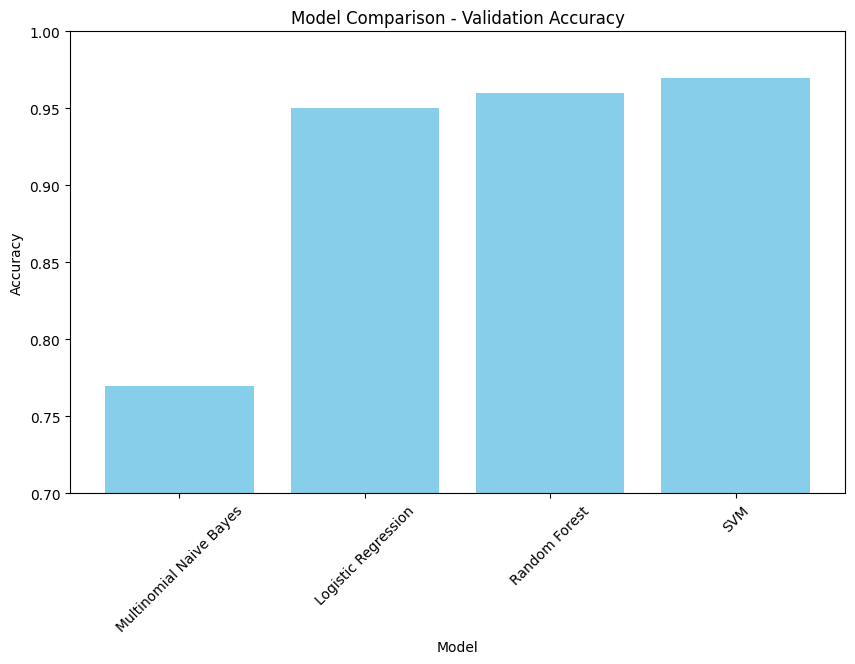

In [46]:
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue')
plt.title('Model Comparison - Validation Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)  # Adjust the y-axis limits if needed
plt.xticks(rotation=45)

In [31]:
print(f"\nBest Model: {best_model} (Validation Accuracy = {best_accuracy:.4f})")


Best Model: SVM (Validation Accuracy = 0.9700)


In [33]:
new_complaints = [
    "I found an error in my credit report and need it corrected.",
    "I keep receiving debt collection calls for a debt I don't owe.",
    "I want to apply for a consumer loan for a car purchase.",
    "I need assistance with my mortgage application process."
]

In [34]:
new_complaints = [preprocess_text(complaint) for complaint in new_complaints]

In [35]:
new_complaints_vectorized = tfidf_vectorizer.transform(new_complaints)

In [36]:
best_model_instance = models[best_model]
predicted_categories = best_model_instance.predict(new_complaints_vectorized)

In [39]:
print(set(predicted_categories))

{'Debt collection', 'Mortgage'}


In [43]:

label_mapping = {
    'Credit reporting, repair, or other': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}


predicted_labels = [label_mapping[label] for label in predicted_categories]


predicted_category_names = [category_names[label] for label in predicted_labels]


In [44]:
print("\nPredictions for New Complaints using Best Model:")
for i in range(len(new_complaints)):
    print(f"Complaint: {new_complaints[i]}")
    print(f"Predicted Category: {predicted_category_names[i]}\n")


Predictions for New Complaints using Best Model:
Complaint: i found an error in my credit report and need it corrected
Predicted Category: Debt collection

Complaint: i keep receiving debt collection calls for a debt i dont owe
Predicted Category: Debt collection

Complaint: i want to apply for a consumer loan for a car purchase
Predicted Category: Mortgage

Complaint: i need assistance with my mortgage application process
Predicted Category: Mortgage

